In [1]:
%run PVModel_functions.ipynb

In [2]:
%run PVsystem_filterfunction_jack-may.ipynb

In [32]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import seaborn as sns
import sklearn
from sklearn.metrics import r2_score
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [4]:
#This is where all the input info should be
#Valid module names : LG, Panasonic, Can270, Can275, HanQPlus, HanQPeak, MissionSolar, Jinko
mod_name = 'Can275'
mettablename =  'dbo.SNLA_Met_DataOut'

In [5]:
#Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
mod_info = pd.read_excel('module_coefficients.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']
#defines the specific module given the previous user input and module coefficients file
module = mod_info[mod_name]
systablename = module['table_name']
#start = '2020-10-01 00:00:00-07:00'
start = module['start']
#end = '2021-01-01 00:00:00-07:00'
end = module['end']

In [6]:
#Import sys & met databases & merge into one df
df = sys_met_data(mettablename, systablename, start, end)

In [7]:
#Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
#merge this information into one solar & environmental data df called 'sedf'

In [8]:
sol_elev_mask = simple_filter(sdf, 'apparent_elevation', lower=15, upper=90, apply=False)
df = df.where(sol_elev_mask, np.nan)

In [9]:
sapm_par = sapm_param(edf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.Temp_C_Avg, df.WS_ms_Mean, 
                   edf['am_abs'], edf['aoi'], module)
sapm_tcell = sapm_par['tcell'].to_frame()
eff_irr  = sapm_par['eff_irr'].to_frame()
temp_irr = pd.merge(sapm_tcell,eff_irr, how = 'inner', left_index=True, right_index=True)
df = df.merge(temp_irr, how='inner', left_index=True, right_index=True)
df = df[~df.index.duplicated(keep='first')]

In [10]:
#Apply physical Filters
df = simple_filter(df, 'eff_irr', lower=50, upper=1200, apply=True)
df = simple_filter(df, 'tcell', lower=-40, upper=85, apply=True)

In [11]:
##### Filter out the data points with a certain ratio of current to irradiance
string_is ='str_1_i', 'str_2_i', 'str_3_i', 'str_4_i'
ratio_names = 'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr', 'ratio str_3_i to eff_irr', 'ratio str_4_i to eff_irr'
for string_i in string_is:
    df['ratio' + ' ' + string_i + ' ' 'to eff_irr'] = df[module[string_i]]/df['eff_irr'] 

for ratio_name in ratio_names:
    df = simple_filter(df, ratio_name, lower=module['ratio_lower'], upper=module['ratio_upper'], apply=True)

In [12]:
#df_hour = df.resample('H').mean()
#df_hour.to_csv(mod_name + 'Met_Hour.csv')

In [13]:
#filter out pole shading 
shade_list = ['Can270', 'HanQPlus']
if mod_name in shade_list:
    shade_start = '2020-10-06 00:00:00-07:00'
    shade_end = '2020-11-02 00:00:00-07:00'
    shask = (df.index > shade_start) & (df.index <= shade_end)
    df = df.loc[~shask]

#remove sep 21
sep_start = '2020-09-21 00:00:00-07:00'
sep_end = '2020-09-22 23:00:00-07:00'
sep_mask = (df.index > sep_start) & (df.index <= sep_end)
df = df.loc[~sep_mask]

#remove feb 5
feb_start = '2020-02-05 00:00:00-07:00'
feb_end = '2020-02-05 23:00:00-07:00'
feb_mask = (df.index > feb_start) & (df.index <= feb_end)
df = df.loc[~feb_mask]


In [14]:
#Generate a results dataframe and add measured values
str_1 = meas_val(df[module['str_1_v']],df[module['str_1_i']])
str_2 = meas_val(df[module['str_2_v']],df[module['str_2_i']])
str_3 = meas_val(df[module['str_3_v']],df[module['str_3_i']])
str_4 = meas_val(df[module['str_4_v']],df[module['str_4_i']])

In [15]:
newresults=[]

In [16]:
hourly_eff_irr = df['eff_irr'].resample('H').mean()

In [17]:
#Calcualte SAPM results and add to df
dc = sapm(df['eff_irr'], df['tcell'], module)
sapm_results = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len']).to_frame()
sapm_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
sapm_results['Str_1'] = str_1
sapm_results['Str_2'] = str_2
sapm_results['Str_3'] = str_3
sapm_results['Str_4'] = str_4
sapm_results['Time'] = sapm_results.index
sapm_results['Year'] = sapm_results.index.year
sapm_results['Model Name'] = 'SAPM'
newresults.append(sapm_results)

In [18]:
#Calculate PVWatts results and add to df
pvw_results = (pvwatts(POA_eff = df['eff_irr'], cell_temp = df['tcell'], 
                             stc_mod_p = module['Power'], Gpmp = module['Gpmp'],str_len = module['str_len'],
                                                 temp_ref=25.0 )).to_frame()
pvw_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
pvw_results['Str_1'] = str_1
pvw_results['Str_2'] = str_2
pvw_results['Str_3'] = str_3
pvw_results['Str_4'] = str_4
pvw_results['Time'] = pvw_results.index
pvw_results['Year'] = pvw_results.index.year
pvw_results['Model Name'] = 'PVW'
newresults.append(pvw_results)

In [19]:
#Calculate CEC results and add to df
cec_param = pvlib.pvsystem.calcparams_cec( df['eff_irr'], df['tcell'], module['alpha_sc'], 
                                          module['a_ref'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], 
                                          module['R_s'], module['Adjust'], module['Cells_in_Series'])
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
cec_results = sdm(cec_p['p_mp'], module['str_len']).to_frame()
cec_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
cec_results['Str_1'] = str_1
cec_results['Str_2'] = str_2
cec_results['Str_3'] = str_3
cec_results['Str_4'] = str_4
cec_results['Time'] = cec_results.index
cec_results['Year'] = cec_results.index.year
cec_results['Model Name'] = 'CEC'
newresults.append(cec_results)

In [20]:
#Calculate Desoto results and add to df
ds_param = pvlib.pvsystem.calcparams_desoto(df['eff_irr'], df['tcell'], module['alpha_sc'],
                                            module['a_ref'],module['I_L_ref'], module['I_o_ref'], 
                                            module['R_sh_ref'], module['R_s'])
ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
des_results = sdm(ds_p['p_mp'], module['str_len']).to_frame()
des_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
des_results['Str_1'] = str_1
des_results['Str_2'] = str_2
des_results['Str_3'] = str_3
des_results['Str_4'] = str_4
des_results['Time'] = des_results.index
des_results['Year'] = des_results.index.year
des_results['Model Name'] = 'DES'
newresults.append(des_results)

In [21]:
#Calculte PVSystem results and add to df
pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['eff_irr'],df['tcell'], module['alpha_sc'], 
                                             module['gamma_ref'],module['mu_gamma'], module['I_L_ref'], module['I_o_ref'],
                                             module['R_sh_ref'], module['R_sh_0'], module['R_s'],  module['Cells_in_Series'])
pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
pvs_results = sdm(pvs_p['p_mp'], module['str_len']).to_frame()
pvs_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
pvs_results['Str_1'] = str_1
pvs_results['Str_2'] = str_2
pvs_results['Str_3'] = str_3
pvs_results['Str_4'] = str_4
pvs_results['Time'] = pvs_results.index
pvs_results['Year'] = pvs_results.index.year
pvs_results['Model Name'] = 'PVS'
newresults.append(pvs_results)

In [22]:
#Import matrix of measurement data
measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
matrix.columns = ['temperature', 'irradiance', 'p_mp']
# calculate efficiency from power
matrix = matrix.eval('eta = p_mp / irradiance')
eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
matrix.eta /= eta_stc.values
# just keep the columns that are needed
matrix = matrix[['irradiance', 'temperature', 'eta']]

#Until the other function is complete, I have this setup just to get out all negative values, but it leads to problems at times
#df.loc[df['BroadbandPOA_Avg']<0, 'BroadbandPOA_Avg'] = 0

In [23]:
#Calculate ADR results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,adr)
adr_eff = adr(df['eff_irr'], df['tcell'], *popt)
adr_results = ((df['eff_irr']/1000) * (adr_eff) * (module['Power']) *12).to_frame()
adr_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
adr_results['Str_1'] = str_1
adr_results['Str_2'] = str_2
adr_results['Str_3'] = str_3
adr_results['Str_4'] = str_4
adr_results['Time'] = adr_results.index
adr_results['Year'] = adr_results.index.year
adr_results['Model Name'] = 'ADR'
newresults.append(adr_results)

In [24]:
#Calculate Heydenreich results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,heydenreich)
hey_eff = heydenreich(df['eff_irr'], df['tcell'], *popt)
hey_results = ((df['eff_irr']/1000) * (hey_eff) * (module['Power']) *12).to_frame()
hey_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
hey_results['Str_1'] = str_1
hey_results['Str_2'] = str_2
hey_results['Str_3'] = str_3
hey_results['Str_4'] = str_4
hey_results['Time'] = hey_results.index
hey_results['Year'] = hey_results.index.year
hey_results['Model Name'] = 'HEY'
newresults.append(hey_results)

In [25]:
#Calculate MotherPV results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,motherpv)
mother_eff = motherpv(df['eff_irr'], df['tcell'], *popt)
mot_results = ((df['eff_irr']/1000) * (mother_eff) * (module['Power']) * 12).to_frame()
mot_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mot_results['Str_1'] = str_1
mot_results['Str_2'] = str_2
mot_results['Str_3'] = str_3
mot_results['Str_4'] = str_4
mot_results['Time'] = mot_results.index
mot_results['Year'] = mot_results.index.year
mot_results['Model Name'] = 'MOT'
newresults.append(mot_results)

In [26]:
#Calculate PVGIS results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,pvgis)
pvgis_eff = pvgis(df['eff_irr'], df['tcell'], *popt)
pvg_results = ((df['eff_irr']/1000) * (pvgis_eff) * (module['Power']) *12).to_frame()
pvg_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
pvg_results['Str_1'] = str_1
pvg_results['Str_2'] = str_2
pvg_results['Str_3'] = str_3
pvg_results['Str_4'] = str_4
pvg_results['Time'] = pvg_results.index
pvg_results['Year'] = pvg_results.index.year
pvg_results['Model Name'] = 'PVG'
newresults.append(pvg_results)

In [27]:
#Calculate MPM5 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm5)
mpm5_eff = mpm5(df['eff_irr'], df['tcell'], *popt)
mpm5_results = ((df['eff_irr']/1000) * (mpm5_eff) * (module['Power']) *12).to_frame()
mpm5_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mpm5_results['Str_1'] = str_1
mpm5_results['Str_2'] = str_2
mpm5_results['Str_3'] = str_3
mpm5_results['Str_4'] = str_4
mpm5_results['Time'] = mpm5_results.index
mpm5_results['Year'] = mpm5_results.index.year
mpm5_results['Model Name'] = 'MPM5'
newresults.append(mpm5_results)

In [28]:
#Calculate MPM6 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm6)
mpm6_eff = mpm6(df['eff_irr'], df['tcell'], *popt)
mpm6_results = ((df['eff_irr']/1000) * (mpm6_eff) * (module['Power']) *12).to_frame()
mpm6_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mpm6_results['Str_1'] = str_1
mpm6_results['Str_2'] = str_2
mpm6_results['Str_3'] = str_3
mpm6_results['Str_4'] = str_4
mpm6_results['Time'] = mpm6_results.index
mpm6_results['Year'] = mpm6_results.index.year
mpm6_results['Model Name'] = 'MPM6'
newresults.append(mpm6_results)

In [29]:
#Calculate Bilinear results and add to df
interpolator = fit_bilinear(**matrix)
bilinear_eff = bilinear(df['eff_irr'], df['tcell'], interpolator)
bil_results = ((df['eff_irr']/1000) * (bilinear_eff) * (module['Power']) * 12).to_frame()
bil_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
bil_results['Str_1'] = str_1
bil_results['Str_2'] = str_2
bil_results['Str_3'] = str_3
bil_results['Str_4'] = str_4
bil_results['Time'] = bil_results.index
bil_results['Year'] = bil_results.index.year
bil_results['Model Name'] = 'BIL'
newresults.append(bil_results)

In [30]:
meta = pd.concat(newresults, ignore_index=True)

In [76]:
pd.options.mode.chained_assignment = None 

In [90]:
#Calculate R2 value for every model
r2=[]
models = ['SAPM', 'PVW', 'CEC', 'DES','PVS', 'ADR', 'HEY', 'MOT', 'PVG', 'MPM5', 'MPM6', 'BIL']
for model in models:
    model_meta = meta.loc[meta['Model Name']==model]
    model_meta.dropna(inplace=True)
    model_r2 =  str(round((r2_score(y_true=model_meta['Str_1'], y_pred=model_meta['Modeled Power'])), 4))
    r2.append(model_r2)

Text(1500, 4000, 'R2 = 0.9907')

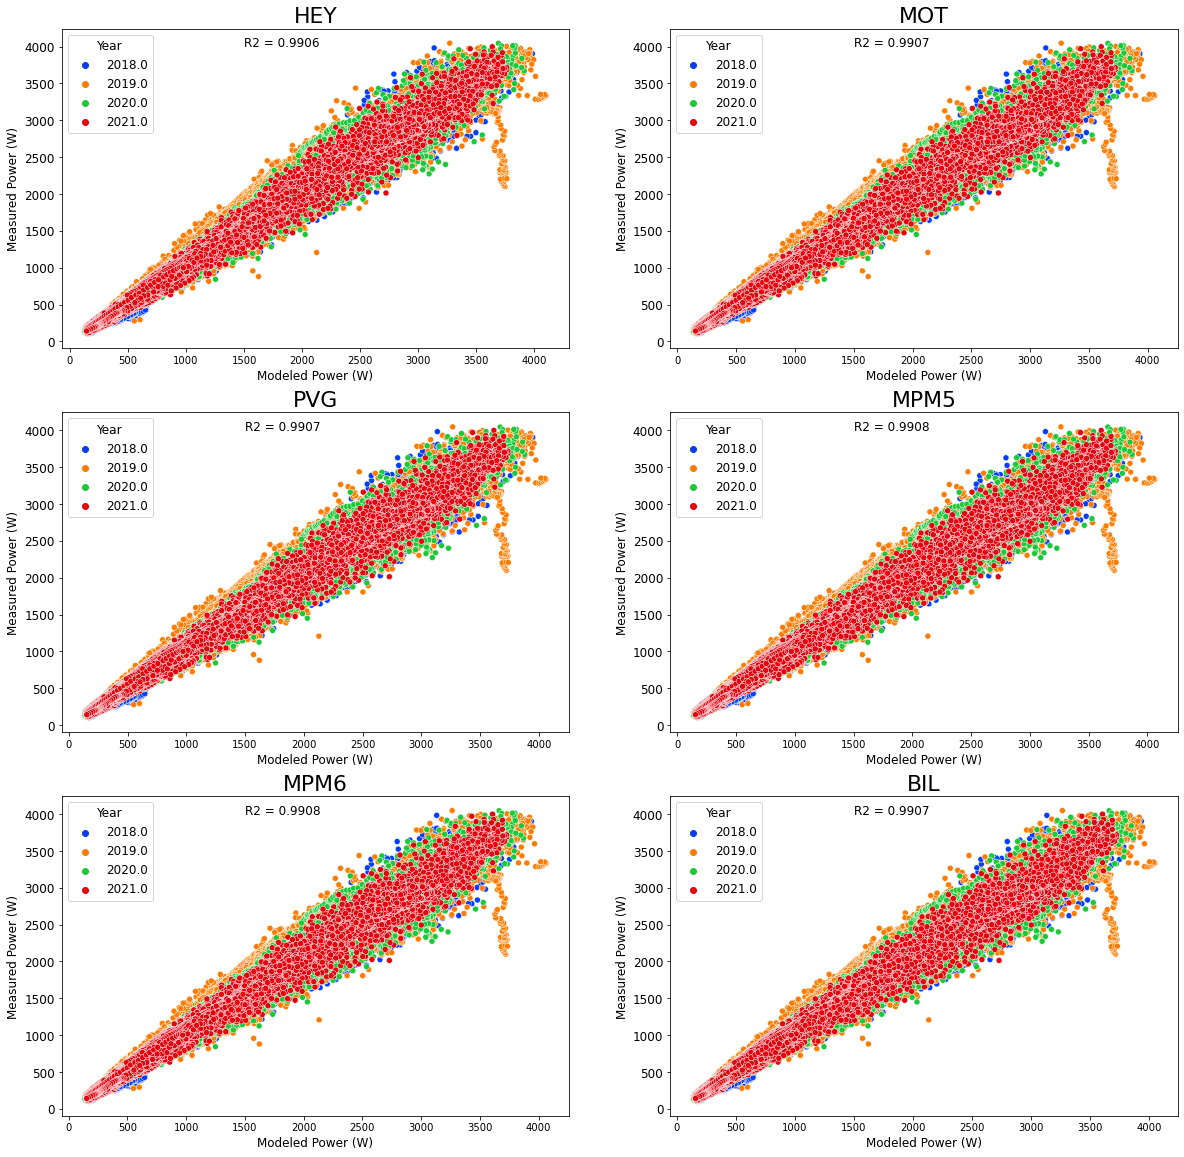

In [97]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[0,0], data=meta.loc[meta['Model Name']=='HEY'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('HEY')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[6]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[0,1], data=meta.loc[meta['Model Name']=='MOT'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('MOT')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[7]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[1,0], data=meta.loc[meta['Model Name']=='PVG'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('PVG')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[8]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[1,1], data=meta.loc[meta['Model Name']=='MPM5'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('MPM5')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[9]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[2,0], data=meta.loc[meta['Model Name']=='MPM6'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('MPM6')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[10]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[2,1], data=meta.loc[meta['Model Name']=='BIL'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('BIL')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[11]))

Text(1500, 4000, 'R2 = 0.9908')

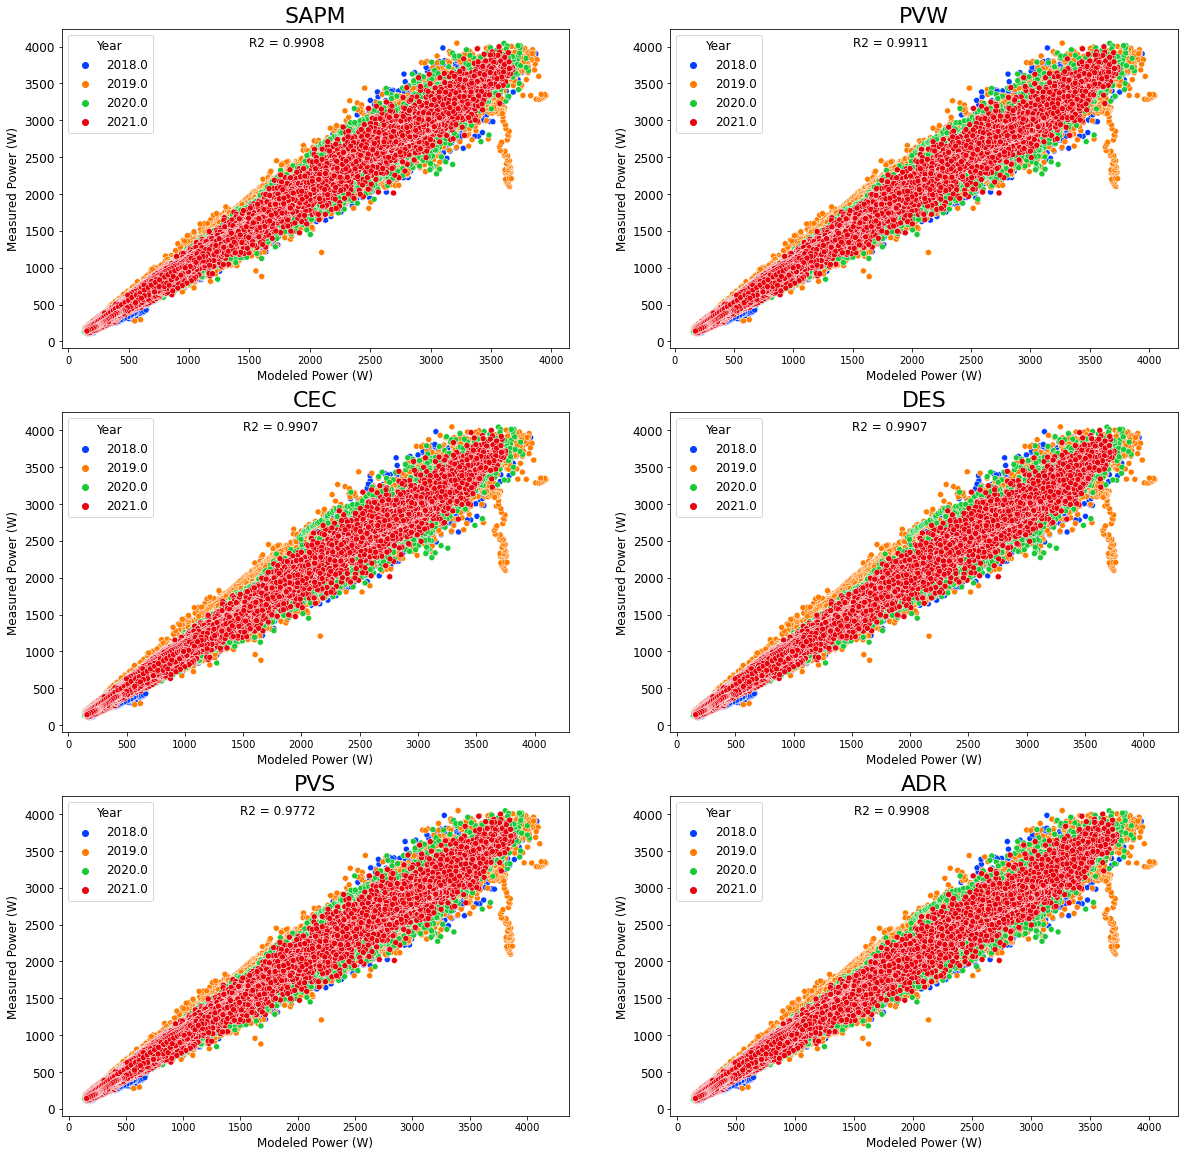

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[0,0], data=meta.loc[meta['Model Name']=='SAPM'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('SAPM')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[0]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[0,1], data=meta.loc[meta['Model Name']=='PVW'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('PVW')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[1]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[1,0], data=meta.loc[meta['Model Name']=='CEC'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('CEC')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[2]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[1,1], data=meta.loc[meta['Model Name']=='DES'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('DES')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[3]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[2,0], data=meta.loc[meta['Model Name']=='PVS'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('PVS')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[4]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[2,1], data=meta.loc[meta['Model Name']=='ADR'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('ADR')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[5]))

In [100]:
strings = ['Str_1','Str_2','Str_3','Str_4']
for string in strings:
    meta['Diff ' + string] = (meta['Modeled Power'] - meta[string])
meta['MBE (W)'] = (meta['Diff Str_1'] + meta['Diff Str_2'] + meta['Diff Str_3'] + meta['Diff Str_4'])/4
for string in strings:
    meta['Abs%Diff ' + string] = 100* abs((meta['Modeled Power'] - meta[string])/(meta[string]))
meta['MAPE (%)'] = ((meta.iloc[:,[13,14,15,16]].mean(axis=1)))

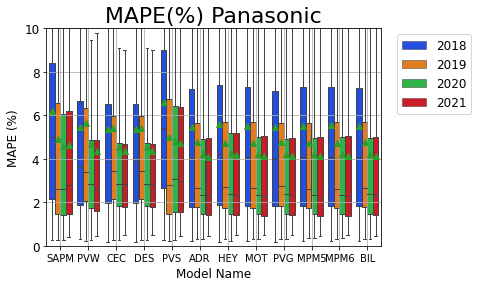

In [33]:
ax = sns.boxplot(x='Model Name', y='MAPE (%)', data = meta, hue='Year', showmeans=True, showfliers=False,palette='bright')
ax.grid(True)
ax.set_ylim([0,10])
ax.set_title('MAPE(%) '+mod_name)
ax.legend(bbox_to_anchor= (1.03, 1))

In [99]:
meta

,Modeled Power,Str_1,Str_2,Str_3,Str_4,Time,Year,Model Name
0,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:00:00-07:00,2018,SAPM
1,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:01:00-07:00,2018,SAPM
2,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:02:00-07:00,2018,SAPM
3,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:03:00-07:00,2018,SAPM
4,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:04:00-07:00,2018,SAPM
...,...,...,...,...,...,...,...,...
20297827,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:56:00-07:00,2021,BIL
20297828,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:57:00-07:00,2021,BIL
20297829,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:58:00-07:00,2021,BIL
20297830,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:59:00-07:00,2021,BIL


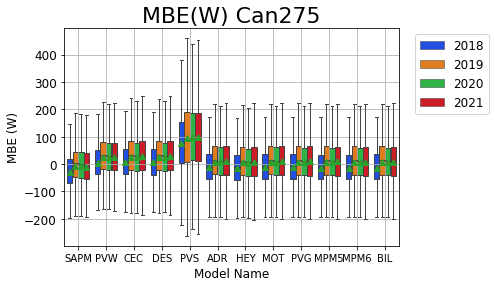

In [101]:
ax = sns.boxplot(x='Model Name', y='MBE (W)', data = meta, hue='Year', showmeans=True, showfliers=False,palette='bright')
ax.grid(True)
#ax.set_ylim([0,10])
ax.set_title('MBE(W) '+mod_name)
ax.legend(bbox_to_anchor= (1.03, 1))

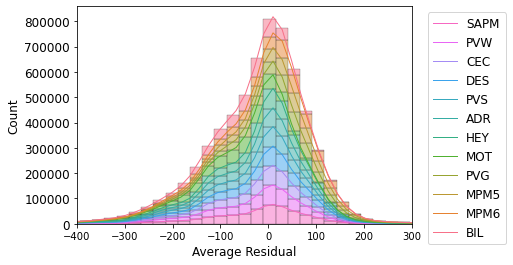

In [50]:
#Average Residuals
ax = sns.histplot(x= "MBE (W)", data=meta,bins=150,  hue="Model Name", kde=True, legend = True,multiple = "stack", fill = True)
ax.set_xlim([-400,300])
ax.set_xlabel('Average Residual')
ax.legend( ['SAPM', 'PVW', 'CEC', 'DES', 'PVS', 'ADR', 'HEY', 'MOT', 'PVG', 'MPM5', 'MPM6', 'BIL'], bbox_to_anchor=(1.03,1), loc='upper left')

In [108]:
meta_2020 = meta.loc[meta['Year']==2020]
resids = [meta_2020['Diff Str_1'],meta_2020['Diff Str_2'],meta_2020['Diff Str_3'],meta_2020['Diff Str_4']]
resids = pd.concat(resids, ignore_index=True)
models = [meta_2020['Model Name'],meta_2020['Model Name'],meta_2020['Model Name'],meta_2020['Model Name']]
models = pd.concat(models, ignore_index=True)
final = pd.concat([resids, models], axis=1)
final.rename(columns = {0 : 'Residual'}, inplace = True)

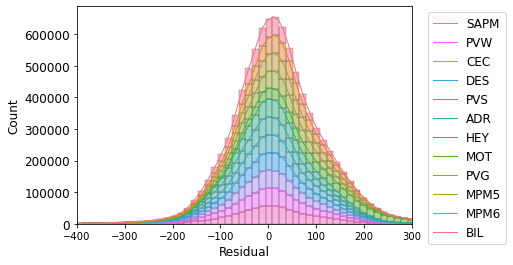

In [109]:
ax = sns.histplot(x= "Residual", data=final,bins=150,  hue="Model Name", kde=True, legend = True,multiple = "stack", fill = True)
ax.set_xlim([-400,300])
ax.set_xlabel('Residual')
ax.legend( ['SAPM', 'PVW', 'CEC', 'DES', 'PVS', 'ADR', 'HEY', 'MOT', 'PVG', 'MPM5', 'MPM6', 'BIL'], bbox_to_anchor=(1.03,1), loc='upper left')

Various plotting saved for formatting

In [ ]:
lg_meta = meta
pan_meta = meta
can275_meta = meta
frames = [lg_meta, pan_meta, can275_meta]
meta_results = pd.concat(frames, ignore_index=True)
meta_results = meta_results.loc[meta_results['Year'] == 2020]
meta_results.rename(columns = {'MAPE' : 'MAPE (%)'}, inplace = True)
ax = sns.boxplot(x = 'System', y = 'MAPE (%)', data = meta_results, showmeans=True, showfliers=False)
ax.grid(True)
#ax.set_ylim([0, 8])
ax.set_title('SAPM MAPE for PVLT Systems')
#ax.legend(bbox_to_anchor= (1.03, 1))

In [ ]:
mape = pd.read_csv('HanQPeak_meta.csv')
ax = sns.boxplot(x = 'Model Name', y = 'MAPE', data = mape,hue='Year', showmeans=True, palette='bright', showfliers=False)
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(loc='upper right')
ax.set_title('Panasonic')

In [182]:
lg_results = meta_results.loc[meta_results['System']=='LG']
pan_results = meta_results.loc[meta_results['System']=='Panasonic']
can275_results = meta_results.loc[meta_results['System']=='Can275']
plt.scatter(dlg_results.index, dlg_results['Str_1'], s=10)
plt.scatter(dlg_results.index, dlg_results['Modeled Power'], s=10)
plt.xlabel(' Time')
plt.ylabel('Power (W)')
plt.title('Measured and SAPM Power for PVLT LG ')
plt.legend(bbox_to_anchor= (1.03, 1), labels=['Measured', 'SAPM'])

In [184]:
lg_results['Modeled Power'].plot()
lg_results['Str_1'].plot()
plt.xlim(datetime.datetime(2020,6, 7, 5), datetime.datetime(2020,6,9,5))
plt.legend( labels=['SAPM', 'Measured'])
plt.xlabel(' Time')
plt.ylabel('Power (W)')
plt.title('Measured and SAPM Power for PVLT LG')